# Problem Statement:

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

# Expected Output:

You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

In [537]:
#Importing all the required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [538]:
# Reading the dataset
boom_bikes = pd.read_csv("day.csv")

In [539]:
#Data Dimensions
boom_bikes.shape

(730, 16)

In [540]:
boom_bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [541]:
#More information about the columns
boom_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [542]:
#checking for Missing Values in the data
boom_bikes.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

# Data Preparation

Observations and corresponding actions on Data:
1. Since the Column 'instant' is record index we can drop the column
    
2. Also the Column 'dteday' seems to be a redundant column as there are columns with year and month values

In [543]:
#Keeping original data intact and Dropping Columns 'Instant' and 'dteday' in new dataframe
boom_bikes1=boom_bikes.drop({'instant','dteday'},axis='columns')

In [544]:
#Since there are two columns related to temperature, checking for the Correlation between temp and atemp as they look mostly similar
boom_bikes1['temp'].corr(boom_bikes1['atemp'])


0.9916961786905648

Since both the columns are highly related, We can drop one of them. 

It seems logical to keep 'atemp' than 'temp' because, Accoriding to Data dictionary, column 'temp' represents actual temperature while column 'atemp' is actual temperature what customer might feel and as we are interested in customer response we can drop the temp column 

In [545]:
#Dropping column 'temp'
boom_bikes1=boom_bikes1.drop({'temp'},axis='columns')

The data dictionary contains the meaning of various attributes; some of which are explored and manipulated here:

In [546]:
# Converting the numeric values in the seasons columns to categoric.

# 1 is spring, 2 is summer, 3 is fall , 4 is winter
boom_bikes1.loc[(boom_bikes['season'] == 1) , 'season'] = 'spring'
boom_bikes1.loc[(boom_bikes['season'] == 2) , 'season'] = 'summer'
boom_bikes1.loc[(boom_bikes['season'] == 3) , 'season'] = 'fall'
boom_bikes1.loc[(boom_bikes['season'] == 4) , 'season'] = 'winter'

In [547]:
# Checking the column values after conversion
boom_bikes1['season'].astype('category').value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [548]:
# viewing the values of the year column - (0: 2018, 1:2019)
boom_bikes1['yr'].astype('category').value_counts()

1    365
0    365
Name: yr, dtype: int64

In [549]:
# Converting the numeric values in the month column to categoric.
def month_names(x):
    return x.map({1: 'Jan', 
                  2: 'Feb', 
                  3: 'Mar', 
                  4: 'Apr', 
                  5: 'May', 
                  6: 'Jun', 
                  7: 'Jul',
                  8: 'Aug',
                  9: 'Sept',
                  10: 'Oct',
                  11: 'Nov',
                  12: 'Dec'})

boom_bikes1[['mnth']] = boom_bikes1[['mnth']].apply(month_names)

In [550]:
boom_bikes1['mnth'].astype('category').value_counts()

Oct     62
May     62
Mar     62
Jul     62
Jan     62
Dec     62
Aug     62
Sept    60
Nov     60
Jun     60
Apr     60
Feb     56
Name: mnth, dtype: int64

In [551]:
#checking the values in the Holidays column
boom_bikes1['holiday'].astype('category').value_counts()

0    709
1     21
Name: holiday, dtype: int64

In [552]:
# Converting the numeric values in the weekday column to categoric.
def week_day(x):
    return x.map({1: 'mon', 2: 'Tue', 3: 'wed', 4: 'thur', 5: 'fri', 6: 'sat', 0: 'sun'})

# Applying the function to the two columns
boom_bikes1[['weekday']] = boom_bikes1[['weekday']].apply(week_day)

In [553]:
boom_bikes1['weekday'].astype('category').value_counts()

mon     105
Tue     105
wed     104
thur    104
sun     104
sat     104
fri     104
Name: weekday, dtype: int64

In [554]:
# Changing the values in the weathersit columns into string values using the data dictonary

boom_bikes1.loc[(boom_bikes1['weathersit'] == 1) , 'weathersit'] = 'clear'
boom_bikes1.loc[(boom_bikes1['weathersit'] == 2) , 'weathersit'] = 'rain'
boom_bikes1.loc[(boom_bikes1['weathersit'] == 3) , 'weathersit'] = 'light snow'
boom_bikes1.loc[(boom_bikes1['weathersit'] == 4) , 'weathersit'] = 'heavy rain'

In [555]:
boom_bikes1['weathersit'].astype('category').value_counts()

clear         463
rain          246
light snow     21
Name: weathersit, dtype: int64

In [556]:
boom_bikes1.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,casual,registered,cnt
0,spring,0,Jan,0,mon,1,rain,18.18125,80.5833,10.749882,331,654,985
1,spring,0,Jan,0,Tue,1,rain,17.68695,69.6087,16.652113,131,670,801
2,spring,0,Jan,0,wed,1,clear,9.47025,43.7273,16.636703,120,1229,1349
3,spring,0,Jan,0,thur,1,clear,10.60610,59.0435,10.739832,108,1454,1562
4,spring,0,Jan,0,fri,1,clear,11.46350,43.6957,12.522300,82,1518,1600


Since the Bike Rental Daily count is predicted based on various environmental and seasonal settings, we can drop the columns that are classifying the customers as casual and registered

In [557]:
#dropping Casual and Registered user counts
boom_bikes1=boom_bikes1.drop({'casual','registered'},axis='columns')

In [558]:
#Checking the Distribution of Data in all columns 
boom_bikes1.describe()

,yr,holiday,workingday,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.690411,23.726322,62.765175,12.763620,4508.006849
std,0.500343,0.167266,0.462641,8.150308,14.237589,5.195841,1936.011647
min,0.000000,0.000000,0.000000,3.953480,0.000000,1.500244,22.000000
25%,0.000000,0.000000,0.000000,16.889713,52.000000,9.041650,3169.750000
50%,0.500000,0.000000,1.000000,24.368225,62.625000,12.125325,4548.500000
75%,1.000000,0.000000,1.000000,30.445775,72.989575,15.625589,5966.000000
max,1.000000,1.000000,1.000000,42.044800,97.250000,34.000021,8714.000000


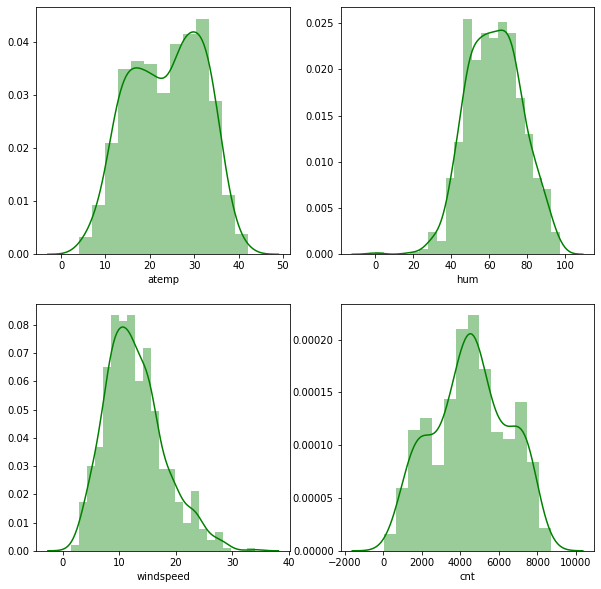

In [559]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.distplot(boom_bikes1['atemp'],color = 'g')

plt.subplot(222)
sns.distplot(boom_bikes1['hum'],color = 'g')

plt.subplot(223)
sns.distplot(boom_bikes1['windspeed'],color = 'g')

plt.subplot(224)
sns.distplot(boom_bikes1['cnt'],color = 'g')

plt.show()

All the Numeric columns seem to have data normally distributed.

Now lets create Dummmy Variables for Columns mnth,season, weathersit and weekday columns

In [560]:
#Creating dummies for Season
dummies=pd.get_dummies(boom_bikes1['season'], drop_first = True)
for i in dummies.columns:
    boom_bikes1['season'+'_'+str(i)]=dummies[i]
boom_bikes1.drop(columns={'season'},inplace=True)

#Creating Dummies for Weekday
dummies=pd.get_dummies(boom_bikes1['weekday'],drop_first=True)
for i in dummies.columns:
    boom_bikes1['weekday'+'_'+str(i)]=dummies[i]
boom_bikes1.drop(columns={'weekday'},inplace=True)

#Creating Dummies for Weather Situation
dummies=pd.get_dummies(boom_bikes1['weathersit'],drop_first=True)
for i in dummies.columns:
    boom_bikes1['weathersit'+'_'+str(i)]=dummies[i]
boom_bikes1.drop(columns={'weathersit'},inplace=True)

#Creating Dummies for Month
dummies=pd.get_dummies(boom_bikes1['mnth'],drop_first=True)
for i in dummies.columns:
    boom_bikes1['mnth'+'_'+str(i)]=dummies[i]
boom_bikes1.drop(columns={'mnth'},inplace=True)

# Visualizing the Data

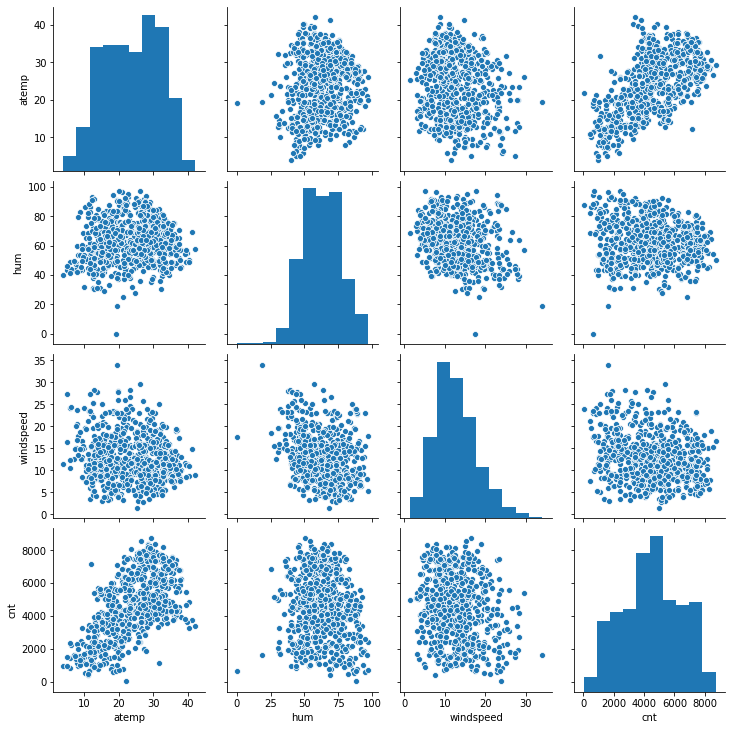

In [561]:
#Pair plots between numeric variables.
sns.pairplot(boom_bikes1[['atemp','hum','windspeed','cnt']])
plt.show()

we can Observe from the above plot that Higher temperatures lead to an increasing number of bike rents and lower temperatures decrease the number of rents and also that Count seems to be distributed uniformly or without a pattern


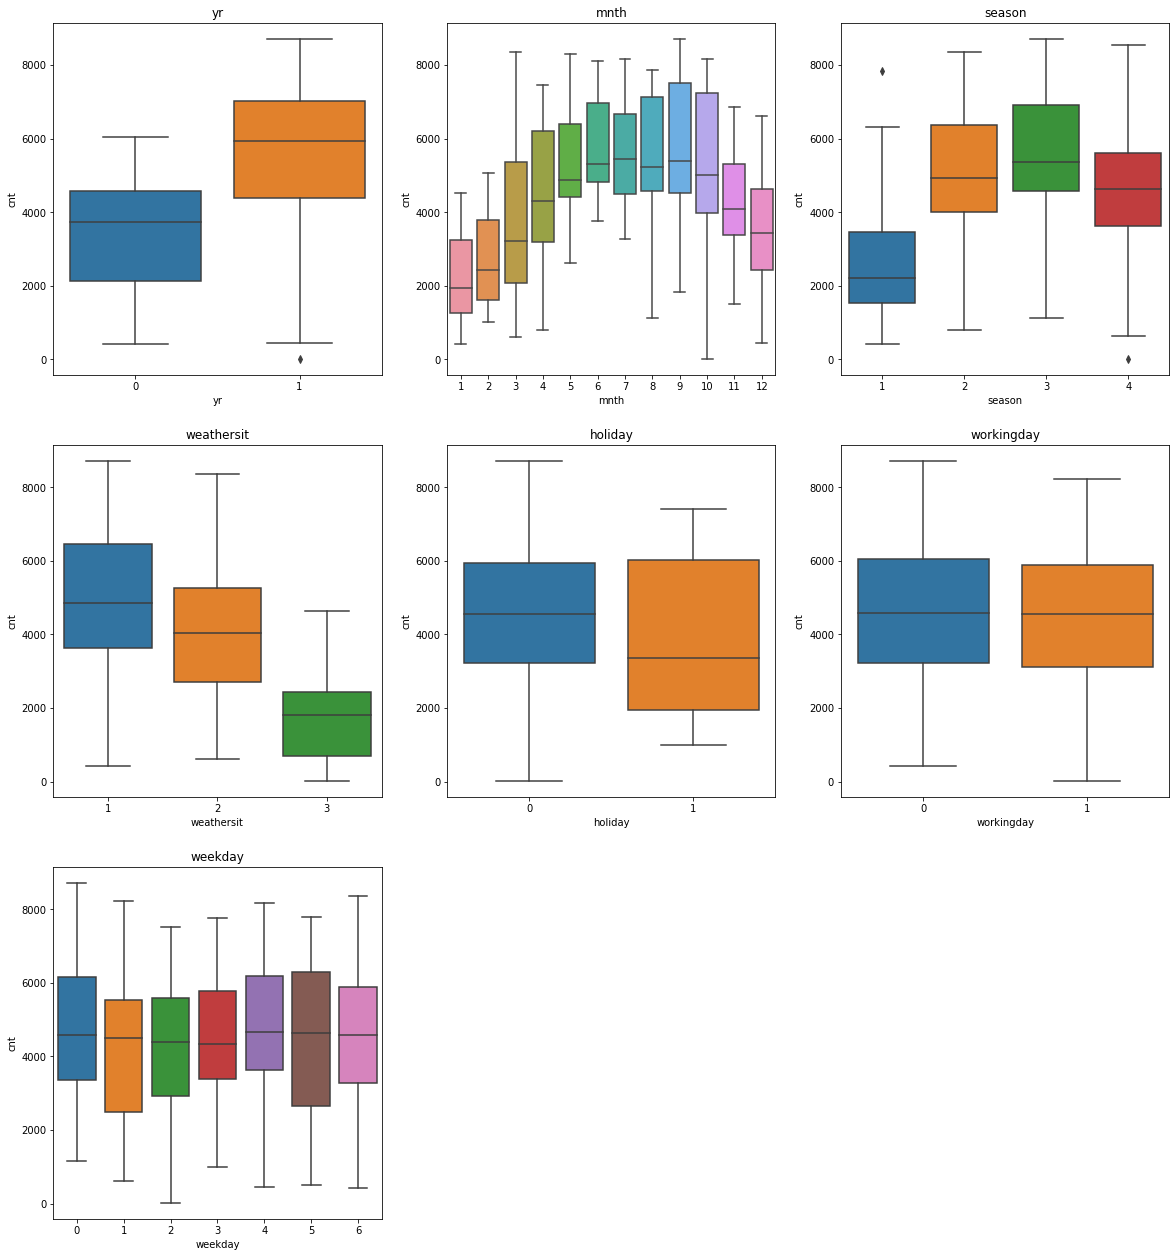

In [562]:
#Distribution of Categorical Variables
plt.figure(figsize=(20, 22))

features = ['yr','mnth','season','weathersit','holiday','workingday','weekday']

for i in enumerate(features):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(x = i[1], y = 'cnt', data = boom_bikes)
    plt.subplots_adjust(hspace=0.2)
    plt.title(i[1])

we observe from the above box plots that the - 
1) The overall count of the rented vehicles is more in the year 2019
2) Certain months have high volume of rented vehicles
3) In clear weather the number of vehicles rented is more

# Selection of Variables

In [563]:
y=boom_bikes1.cnt
X=boom_bikes1.drop('cnt',axis=1)

In [564]:
boom_bikes1.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sept
0,0,0,1,18.18125,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,1,17.68695,69.6087,16.652113,801,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,9.47025,43.7273,16.636703,1349,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,10.60610,59.0435,10.739832,1562,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,11.46350,43.6957,12.522300,1600,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [565]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

Scaling

In [566]:
Scaler=MinMaxScaler()
obj=Scaler.fit(X_train[['atemp', 'hum','windspeed']])
X_train[['atemp', 'hum','windspeed']]=obj.transform(X_train[['atemp', 'hum','windspeed']])

Identifying the top significant variables using Recursive Feature Elimination(automated approach)

In [567]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [568]:
RFE=pd.DataFrame()
RFE['Feature']=X_train.columns
RFE['support']=rfe.support_
RFE['ranking']=rfe.ranking_
RFE.sort_values('ranking')

,Feature,support,ranking
0,yr,True,1
25,mnth_Nov,True,1
20,mnth_Jan,True,1
19,mnth_Feb,True,1
18,mnth_Dec,True,1
17,mnth_Aug,True,1
16,weathersit_rain,True,1
15,weathersit_light snow,True,1
27,mnth_Sept,True,1
4,hum,True,1


In [569]:
Features=list(RFE[RFE['ranking']==1].Feature.reset_index(drop=True))
Features

['yr',
 'holiday',
 'atemp',
 'hum',
 'windspeed',
 'season_summer',
 'season_winter',
 'weathersit_light snow',
 'weathersit_rain',
 'mnth_Aug',
 'mnth_Dec',
 'mnth_Feb',
 'mnth_Jan',
 'mnth_Nov',
 'mnth_Sept']

 Feature selection

1. When a feature has high p-value and high VIF, then it can be dropped first.
2. When a feature has high p-value and low VIF, then we will drop it as it is not significant.
3. When a feature has low p-value and high VIF, we try to drop other features which have higher p-value and if there is none, we will remove this feature and build the model and check the R-squared.
4. When a feature has low p-value and low VIF, then it is significant and not explained by other features and hence we keep these features in the model.

> Now that we have 15 top features after RFE, We will conduct Feature Selection One by one based on p-value and VIF 

In [570]:

def Model(Features):
    X_train_temp = X_train[Features] # get feature list 
    X_train_temp = sm.add_constant(X_train_temp) # required by statsmodels 
    lr = sm.OLS(y_train, X_train_temp).fit() # build model and learn coefficients
    print(lr.summary())
    vif(Features)# OLS summary with R-squared, adjusted R-squared, p-value etc.
def vif(Features):
    vif = pd.DataFrame()
    vif['Features'] = X_train[Features].columns # Read the feature names
    vif['ViF'] = [variance_inflation_factor(X_train[Features].values,i) for i in range(X_train[Features].shape[1])] # calculate VIF
    vif['ViF'] = round(vif['ViF'],2)
    vif.sort_values(by='ViF', ascending = False, inplace=True)  
    print(vif.reset_index(drop=True)) # prints the calculated VIFs for all the features

Model-1 with all features from RFE

In above Summary statistics, 
1. All the features seem very significant with p-value being less than 0.05. 
2. VIFs for few variables are very high which show collinearity. 

In [571]:
Set1=Features.copy()
Model(Set1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     175.1
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          1.26e-186
Time:                        19:05:52   Log-Likelihood:                -4117.2
No. Observations:                 510   AIC:                             8266.
Df Residuals:                     494   BIC:                             8334.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2574.20

Model-2 by eliminating column 'hum' as it has a very high VIF value.  

In [572]:
set2=Features.copy()
set2.remove('hum')
Model(set2)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     180.0
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          7.00e-184
Time:                        19:05:52   Log-Likelihood:                -4126.5
No. Observations:                 510   AIC:                             8283.
Df Residuals:                     495   BIC:                             8346.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1859.59

Model-3 By Eliminating 'mnth_Nov
'

In this model, We dont see a huge dip in the R-squared and Values of R-squared and Adj. R-squared got closer so this is a good elimination.

In [573]:
set3=Features.copy()
set3.remove('mnth_Nov')
Model(set3)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     185.6
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          1.29e-186
Time:                        19:05:53   Log-Likelihood:                -4120.0
No. Observations:                 510   AIC:                             8270.
Df Residuals:                     495   BIC:                             8333.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2448.07

Model-4 : By eliminating Humidity 

> In this model, We dont see a huge difference in R-squared while the VIFs of other variables like temperatures have decreased. Hence this is a good elimination.

In [574]:
set4=set3.copy()

set4.remove('hum')
Model(set4)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     191.9
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          6.59e-184
Time:                        19:05:53   Log-Likelihood:                -4129.2
No. Observations:                 510   AIC:                             8286.
Df Residuals:                     496   BIC:                             8346.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1731.98

Model-5 By Eliminating 'mnth_Feb' from Features4



In [575]:
set5=set4.copy()
set5.remove('mnth_Feb')
Model(set5)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     205.8
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          5.22e-184
Time:                        19:05:53   Log-Likelihood:                -4131.7
No. Observations:                 510   AIC:                             8289.
Df Residuals:                     497   BIC:                             8344.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1474.59

Model-6 By Eliminating 'mnth_Dec' from Features5

here, We eliminated 'mnth_Dec' because it had p-value='0.063' which is greater than 0.05. No change in R-squred value indicated, its a good elimination.

In [576]:
set6=set5.copy()
set6.remove('mnth_Dec')
Model(set6)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     223.1
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          1.91e-184
Time:                        19:05:53   Log-Likelihood:                -4133.5
No. Observations:                 510   AIC:                             8291.
Df Residuals:                     498   BIC:                             8342.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1369.05

Model-7 by Removing 'Month_10' from Features6

In Model-6, 'Month_10' had p-value=0.045. Model-7 after elimination of 'Month_10' has almost similar R-squared as Model-6. So this is a good elimination.

In [577]:
set7=set6.copy()
set7.remove('mnth_Jan')
Model(set7)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     242.0
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          3.10e-184
Time:                        19:05:53   Log-Likelihood:                -4136.8
No. Observations:                 510   AIC:                             8296.
Df Residuals:                     499   BIC:                             8342.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1134.81

Model-8 By Removing 'Mnth_Aug' from Features7

While Model-7 has all variables significant, We still see temperature having high VIF, after determining correlations of all variables of Features7, we find that Temperature is highly correlated with Month_8. 

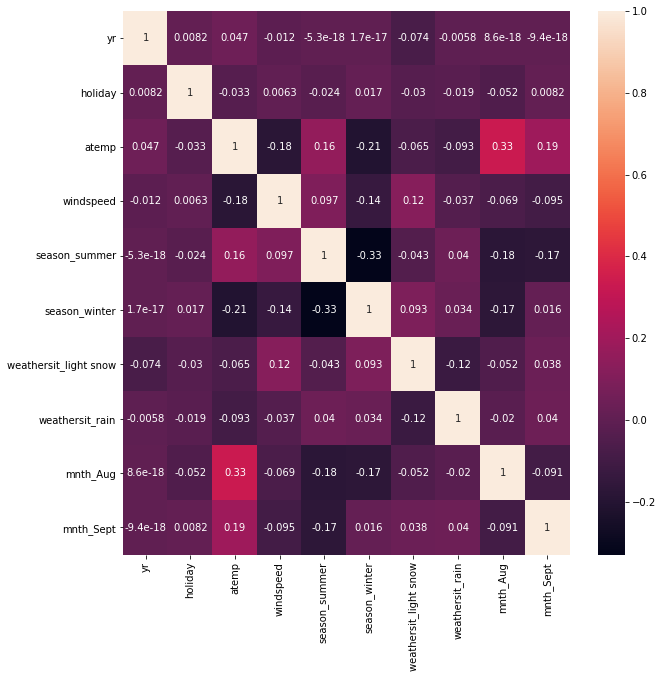

In [578]:
plt.figure(figsize=(10,10))
sns.heatmap(boom_bikes1[set7].corr(), annot = True)
plt.show()

In [579]:
set8=set7.copy()
set8.remove('mnth_Aug')
Model(set8)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     259.0
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          6.28e-182
Time:                        19:05:55   Log-Likelihood:                -4145.1
No. Observations:                 510   AIC:                             8310.
Df Residuals:                     500   BIC:                             8353.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1089.05

# Model Building

After trying various combinations of features we are left with 9 features ['atemp  ','windspeed  ','yr  ','season_summer  ','weathersit_rain  ','mnth_Sept      ','weathersit_light snow','holiday  '] which explain the variance in the model by R-squared value of 82.3%. 

We can use this model

In [580]:
X_train_final=X_train[set8]
X_train_final = sm.add_constant(X_train_final) 
lr=sm.OLS(y_train,X_train_final).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     259.0
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          6.28e-182
Time:                        19:05:55   Log-Likelihood:                -4145.1
No. Observations:                 510   AIC:                             8310.
Df Residuals:                     500   BIC:                             8353.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1089.05

# Interpreting the regression results of Train Dataset

In [581]:
#Scaling y For better Interpretation after we get final features
y_train_scaled=pd.DataFrame(y_train)
scaler_y = MinMaxScaler()
scaled_array = scaler_y.fit_transform(y_train_scaled)
y_train_scaled=pd.DataFrame(scaled_array,columns=['cnt'])

In [582]:
X_train_final=X_train[set8]
X_train_final = sm.add_constant(X_train_final) 
lr=sm.OLS(y_train_scaled.cnt.values.reshape(-1,1),X_train_final).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     259.0
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          6.28e-182
Time:                        19:05:55   Log-Likelihood:                 480.64
No. Observations:                 510   AIC:                            -941.3
Df Residuals:                     500   BIC:                            -898.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.12

 Observations about the Models
* here the R-squared of the model(82.3%) and adjusted R-sqaured(82.0%) indicates that the  8 features selected are significant for our prediction.
* P(F-statistic) of the model is close to 0 which indicates that this model is a good fit.
* Coefficients of the features indicate how they are related with cnt.

Top 3 significant features that contribute towards explaining towards the demand of the shared bikes:

* Temperature with coefficient 0.57 indicating as temperature increases, the demand for bikes increase.
* Weather situation like light snow and Rain have negative coefficient of  -0.2779 and -.0802 respectively, which indicate that the demand for bikes decreases during these conditions.
* Year with coefficient 0.2339 indicating that the bike demand has increased from last year and is expected to increase in future.

In [583]:
X_train_final=X_train[set8]
X_train_final = sm.add_constant(X_train_final) 
lr=sm.OLS(y_train,X_train_final).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     259.0
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          6.28e-182
Time:                        19:05:55   Log-Likelihood:                -4145.1
No. Observations:                 510   AIC:                             8310.
Df Residuals:                     500   BIC:                             8353.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1089.05

Cnt = 
(1089.0571)+
(2033.0121) * yr + 
(-838.7009) * holiday + 
(5003.9006) * temp + 
(-1178.9376) * windspeed + 
(704.2682) * season_summer+ 
(1059.1021) * season_winter + 
(-2415.1066) * weathersit_light snow(ie. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ) +
(-697.1759) * weathersit_rain(ie. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds) +
(887.8912) * mnth_Sep


# Model Evaluation of Train Dataset


Assumptions of Linear Regression:

Linear regression model is based on the following assumption and we will prove these assumptions with the model we built:

1) Linear relationship between X and Y: This was proved in the pair plot
2) Error terms are normally distributed
3) Error terms are independent of each other
4) Error terms have constant variance (homoscedasticity)

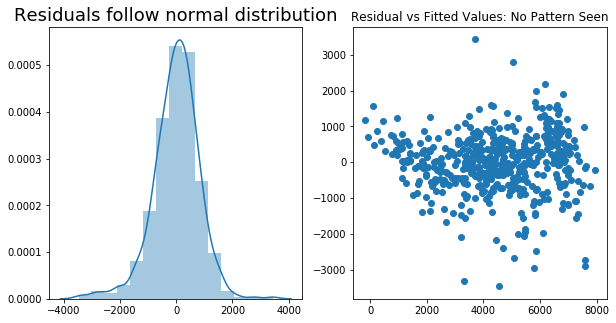

In [584]:
y_train_predicted = lr.predict(X_train_final) # get predicted value on training dataset using statsmodels predict()
residual_values = y_train - y_train_predicted # difference in actual Y and predicted value
plt.figure(figsize=[10,5])
plt.subplot(121)
sns.distplot(residual_values, bins = 15) # Plot the histogram of the error terms
plt.title('Residuals follow normal distribution', fontsize = 18)
plt.subplot(122) 
plt.scatter(y_train_predicted, residual_values) # Residual vs Fitted Values
plt.plot([0,0],'r') # draw line at 0,0 to show that residuals have constant variance
plt.title('Residual vs Fitted Values: No Pattern Seen')
plt.show()

<b>INFERENCES:</b>
* From first plot, it can be proved that Residuals follow normal distribution and centered around zero
* From second plot, it can be proved that Residuals do not follow any pattern indicating error terms are independent
* Also from second plot, we can see that Error terms have constant variance and do not exhibit Heteroskedasticity

# Metrics of Train Dataset

<b>Root mean square error ( RMSE )</b>

In [585]:
from math import sqrt
train_rmse = sqrt(mean_squared_error(y_train,y_train_predicted))
print('Root mean square error :',train_rmse)

Root mean square error : 819.5814115841573


<b>Mean absolute error (MAE)</b>

In [586]:
train_mae=mean_absolute_error(y_train,y_train_predicted)
print('Mean absolute error :',train_mae)

Mean absolute error : 607.4945428339882


<b>R2 Score</b> 

In [587]:
train_r2 = round(r2_score(y_train, y_train_predicted),3)
print('R2 Score :',train_r2)

R2 Score : 0.823


<b>Adjusted R2 Score</b>

In [588]:
n = X_train_final.shape[0]
p = len(Features8)
train_Adj_R2=round(1-(1-train_r2)*(n-1)/(n-p-1),3) 
print('Adjusted R2 Score:',train_Adj_R2)

Adjusted R2 Score: 0.82


# Testing the model using Test Dataset

<b>Scaling</b> 

In [589]:
#Scaling the Test Dataset using Object used while Scaling Train Dataset
X_test[['atemp', 'hum','windspeed']]=obj.transform(X_test[['atemp', 'hum','windspeed']])

In [590]:
#Selecting The final 9 Features
X_test_final=X_test[set8]

In [591]:
X_test_final = sm.add_constant(X_test_final)
y_test_predicted = lr.predict(X_test_final)

# Comparison of R2 Metrics for Test and Train Data


 <b>R2 Score</b>

In [592]:
train_r2 = round(r2_score(y_train, y_train_predicted),3)
test_r2 = round(r2_score(y_test, y_test_predicted),3)
print('R2 Score of Train and Test Datasets are:',train_r2,' and ',test_r2)

R2 Score of Train and Test Datasets are: 0.823  and  0.795


<b>Adjusted R2 Score</b>

In [593]:
n = X_test_final.shape[0]
p = len(Features8)
test_Adj_R2=round(1-(1-test_r2)*(n-1)/(n-p-1),3) 
print('Adjusted R2 Score of Train and Test Datasets are:',train_Adj_R2,' and ',test_Adj_R2)

Adjusted R2 Score of Train and Test Datasets are: 0.82  and  0.786


# Conclusion

In conclusion, for USA market, Data suggests the following remarks on demand of rental bikes:
1. The number of vehicles rented is increasing Year by Year.
2. In USA it is not preferable to use Rental bikes on Holidays and when temperature is low.
3. In case of high winds,customers tend to not use rental bikes
4. September is the month in which customers are likely to use rental bikes more.
5. Summer and Winter seasons have been preferred by customers to use rental bikes
